In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [4]:
df = pd.read_csv("data/processed/survey_ai_usage_clean_filtered.csv")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33065 entries, 0 to 33064
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   DevType                 33065 non-null  category
 1   WorkExp                 33065 non-null  float64 
 2   LanguageHaveWorkedWith  33065 non-null  object  
 3   Country                 33065 non-null  category
 4   RemoteWork              33065 non-null  category
 5   Industry                33065 non-null  category
 6   OrgSize                 33065 non-null  category
 7   EdLevel                 33065 non-null  category
 8   AI_Usage                33065 non-null  int64   
 9   NumLanguages            33065 non-null  int64   
dtypes: category(6), float64(1), int64(2), object(1)
memory usage: 1.2+ MB


In [5]:
# --- Variables predictoras y objetivo ---
X = df.drop(columns=['AI_Usage'])
y = df['AI_Usage']

# --- Identificar columnas categóricas y numéricas ---
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

In [6]:
print(cat_cols)
print(num_cols)

Index(['DevType', 'LanguageHaveWorkedWith', 'Country', 'RemoteWork',
       'Industry', 'OrgSize', 'EdLevel'],
      dtype='object')
Index(['WorkExp', 'NumLanguages'], dtype='object')


In [7]:
# Columnas categóricas que queremos convertir
cat_cols = [
    "DevType", "Country", "RemoteWork", "Industry", "OrgSize", "EdLevel"
]

# Convertir a tipo category
for col in cat_cols:
    df[col] = df[col].astype("category")

# Verificamos el resultado
df.dtypes[cat_cols]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33065 entries, 0 to 33064
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   DevType                 33065 non-null  category
 1   WorkExp                 33065 non-null  float64 
 2   LanguageHaveWorkedWith  33065 non-null  object  
 3   Country                 33065 non-null  category
 4   RemoteWork              33065 non-null  category
 5   Industry                33065 non-null  category
 6   OrgSize                 33065 non-null  category
 7   EdLevel                 33065 non-null  category
 8   AI_Usage                33065 non-null  int64   
 9   NumLanguages            33065 non-null  int64   
dtypes: category(6), float64(1), int64(2), object(1)
memory usage: 1.2+ MB


In [8]:
df.to_parquet("data/processed/survey_ai_usage_clean_filtered.parquet", index=False)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # Import the os module

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

# 1) Datos
X = df.drop(columns=['AI_Usage'])
y = df['AI_Usage']

# Correctly identify categorical and numerical columns based on dtypes
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    ('num', StandardScaler(), num_cols)
])

models = {
    'Logistic Regression (sin balance)': LogisticRegression(max_iter=1000),
    'Logistic Regression (balanceado)': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest (sin balance)': RandomForestClassifier(n_estimators=200, random_state=42),
    'Random Forest (balanceado)': RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
}

# Pequeña función para generar nombres de archivo limpios
def slugify(name: str) -> str:
    return (
        name.lower()
            .replace(' ', '_')
            .replace('(', '')
            .replace(')', '')
            .replace('á', 'a')
            .replace('é', 'e')
            .replace('í', 'i')
            .replace('ó', 'o')
            .replace('ú', 'u')
    )

# Ensure the directory exists
output_dir = "docs/assets/charts"
os.makedirs(output_dir, exist_ok=True)

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Entrenar, evaluar y guardar info para ROC y confusion matrix
rows = []
roc_data = {}

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)

    # Predicciones duras
    y_pred = pipe.predict(X_test)
    # Probabilidades para ROC (clase positiva = 1)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    # === Matriz de confusión ===
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=[0, 1],
        yticklabels=[0, 1]
    )
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de confusión - {name}")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/confusion_matrix_{slugify(name)}.png", dpi=300)
    plt.close()

    # === Métricas de clasificación ===
    rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    # === Curva ROC y AUC ===
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_value = roc_auc_score(y_test, y_proba)

    rows.append({
        'Modelo': name,
        'Accuracy': rep['accuracy'],
        'Precision (1)': rep['1']['precision'],
        'Recall (1)': rep['1']['recall'],
        'F1-score (1)': rep['1']['f1-score'],
        'ROC-AUC': auc_value
    })

    roc_data[name] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': auc_value
    }

# 4) Tabla resumen de resultados
df_results = pd.DataFrame(rows).sort_values(
    by='F1-score (1)',
    ascending=False
).reset_index(drop=True)

print(df_results.round(3))

# Guardar tabla
df_results.round(3).to_csv(f"{output_dir}/model_comparison_table.csv", index=False)
df_results.to_html(
    f"{output_dir}/model_comparison_table.html",
    index=False,
    float_format=lambda x: f"{x:.3f}"
)

# 5) Gráfico con TODAS las curvas ROC juntas
plt.figure(figsize=(8, 6))
for name, data in roc_data.items():
    plt.plot(
        data['fpr'],
        data['tpr'],
        label=f"{name} (AUC = {data['auc']:.3f})"
    )

plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel("False Positive Rate (1 - Especificidad)")
plt.ylabel("True Positive Rate (Sensibilidad)")
plt.title("Curvas ROC comparadas")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"{output_dir}/roc_curves_all_models.png", dpi=300)
plt.close()

# 6) Gráfico de comparación de métricas (Accuracy, Precision, F1)
plot_df = df_results.melt(
    id_vars='Modelo',
    value_vars=['Accuracy', 'Precision (1)', 'F1-score (1)'],
    var_name='Métrica',
    value_name='Valor'
)

plt.figure(figsize=(9, 6))
sns.barplot(data=plot_df, x='Modelo', y='Valor', hue='Métrica')
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 1)
plt.title("Comparación de métricas por modelo")
plt.tight_layout()
plt.savefig(f"{output_dir}/model_metrics_comparison.png", dpi=300)
plt.close()

                              Modelo  Accuracy  Precision (1)  Recall (1)  \
0        Random Forest (sin balance)     0.790          0.794       0.992   
1  Logistic Regression (sin balance)     0.791          0.800       0.980   
2         Random Forest (balanceado)     0.788          0.795       0.987   
3   Logistic Regression (balanceado)     0.674          0.845       0.719   

   F1-score (1)  ROC-AUC  
0         0.882    0.648  
1         0.881    0.673  
2         0.880    0.659  
3         0.777    0.667  


In [13]:
df_results.to_parquet("data/processed/model_comparison_results.parquet", index=False)

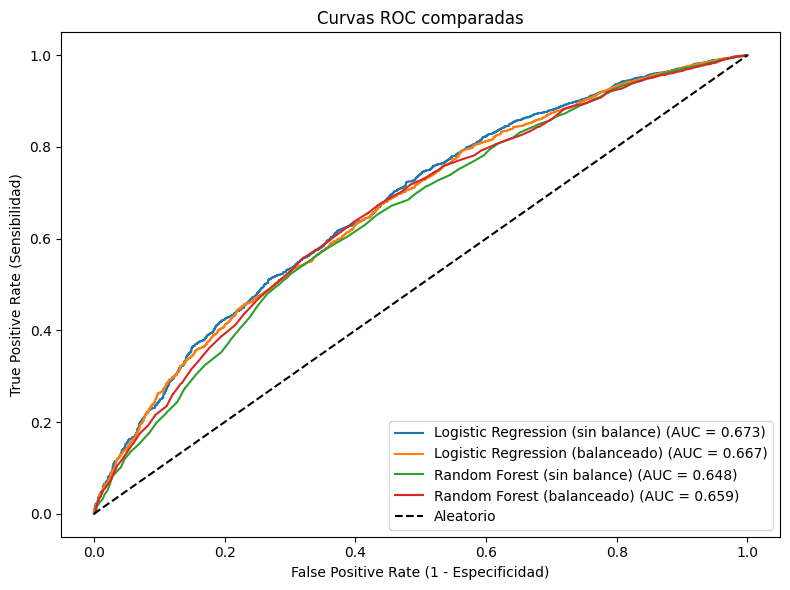

In [17]:
# 5) Gráfico con TODAS las curvas ROC juntas
plt.figure(figsize=(8, 6))
for name, data in roc_data.items():
    plt.plot(
        data['fpr'],
        data['tpr'],
        label=f"{name} (AUC = {data['auc']:.3f})"
    )

plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel("False Positive Rate (1 - Especificidad)")
plt.ylabel("True Positive Rate (Sensibilidad)")
plt.title("Curvas ROC comparadas")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"{output_dir}/roc_curves_all_models.png", dpi=300)
plt.show()
plt.close()

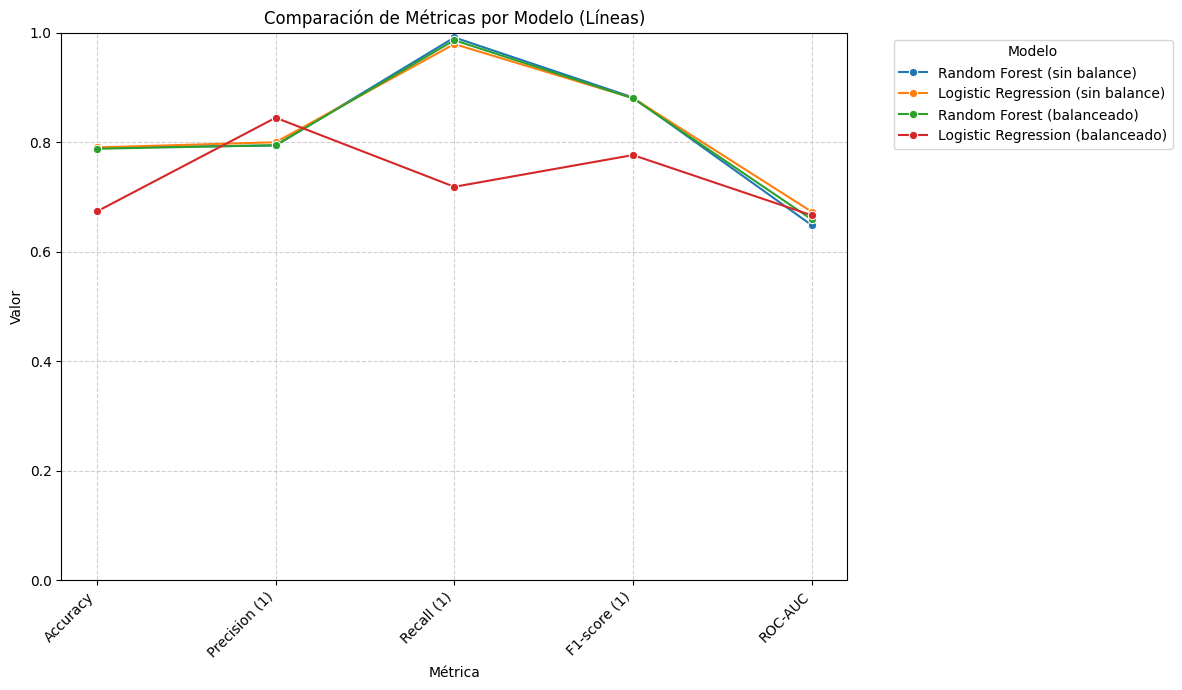

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure the output directory exists
output_dir = "docs/assets/charts"
os.makedirs(output_dir, exist_ok=True)

# Prepare data for plotting: melt df_results to long format
plot_df_line = df_results.melt(
    id_vars='Modelo',
    value_vars=['Accuracy', 'Precision (1)', 'Recall (1)', 'F1-score (1)', 'ROC-AUC'],
    var_name='Métrica',
    value_name='Valor'
)

# Create the line plot
plt.figure(figsize=(12, 7))
sns.lineplot(data=plot_df_line, x='Métrica', y='Valor', hue='Modelo', marker='o')

plt.title('Comparación de Métricas por Modelo (Líneas)')
plt.xlabel('Métrica')
plt.ylabel('Valor')
plt.ylim(0, 1) # Metrics are between 0 and 1
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{output_dir}/model_metrics_comparison_line.png", dpi=300)
plt.show()

In [16]:
import plotly.express as px
import os

# Ensure the output directory exists
output_dir = "docs/assets/charts"
os.makedirs(output_dir, exist_ok=True)

# Create the interactive line plot using Plotly Express
fig = px.line(
    plot_df_line,
    x='Métrica',
    y='Valor',
    color='Modelo',
    markers=True,
    title='Comparación de Métricas por Modelo (Plotly)',
    labels={
        'Métrica': 'Métrica',
        'Valor': 'Valor'
    }
)

# Customize layout
fig.update_layout(
    yaxis_range=[0.6, 1.05], # Adjusted y-axis range to zoom in on values
    xaxis_title='Métrica',
    yaxis_title='Valor',
    legend_title='Modelo',
    hovermode='x unified' # Enable unified hover for better comparison
)

fig.update_xaxes(tickangle=45)

# Save the plot as an HTML file
plotly_output_path = f"{output_dir}/model_metrics_comparison_plotly.html"
fig.write_html(plotly_output_path)

# Display the plot
fig.show()

In [2]:
df = pd.read_parquet("data/processed/survey_ai_usage_clean_filtered.parquet")

In [ ]:
X = df.drop('AI_Usage', axis=1, errors='ignore')
y = df['AI_Usage']

# Drop the 'LanguageHaveWorkedWith' column as requested
X = X.drop('LanguageHaveWorkedWith', axis=1)

# Identify numerical and categorical columns for preprocessing
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Create a preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression (sin balance)": LogisticRegression(max_iter=1000),
    "Random Forest (sin balance)"      : RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
}

results = []

for name, clf in models.items():
    pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', clf)
    ])

    f1_scores = cross_val_score(
        pipe,
        X,
        y,
        cv=skf,
        scoring='f1'
    )

    results.append({
        "Modelo": name,
        "F1_mean": f1_scores.mean(),
        "F1_std": f1_scores.std()
    })

df_cv_results = pd.DataFrame(results)
df_cv_results.to_parquet("data/processed/crossval_model_comparison.parquet", index=False)
print(df_cv_results)

                              Modelo   F1_mean    F1_std
0  Logistic Regression (sin balance)  0.881751  0.001537
1        Random Forest (sin balance)  0.875243  0.002326


Interpretación de los resultados de la validación cruzada (k=5)

Se aplicó validación cruzada estratificada con 5 particiones para estimar el rendimiento real de cada modelo.

La regresión logística obtuvo un F1-score promedio de 0.8817, con una desviación estándar de 0.0015, lo que indica un rendimiento altamente estable en todos los folds.

El Random Forest obtuvo un F1-score promedio de 0.8752, también con baja varianza.

Ambos modelos superan el criterio de éxito establecido (F1 ≥ 0.80).

Sin embargo, la regresión logística se selecciona como modelo final debido a su mejor equilibrio entre desempeño, estabilidad e interpretabilidad.